In [2]:
# %pip install torch matplotlib seaborn numpy pandas torchvision torchaudio

In [3]:
import pandas as pd
import numpy as np
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from os import path

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


In [4]:
df = pd.read_csv("jena_climate_2009_2016.csv")[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [5]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [6]:
# correct for windspeeds < 0
df['wv (m/s)'][df['wv (m/s)'] < 0] = 0
df['max. wv (m/s)'][df['max. wv (m/s)'] < 0] = 0
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

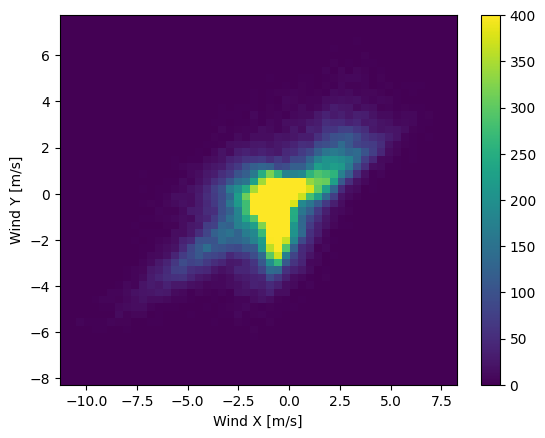

In [7]:
# convert the wind degrees and wind speed to a wind vector
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

<Axes: >

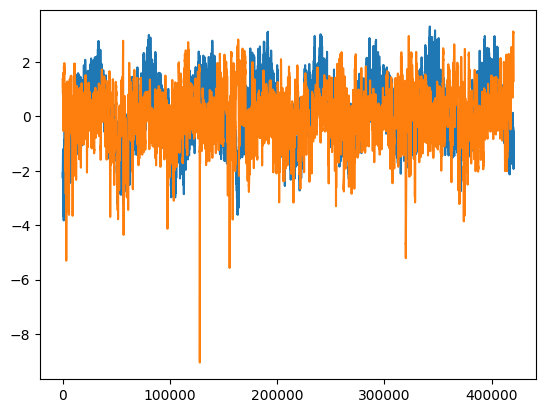

In [8]:
# standardize all numeric features
df = (df-df.mean(axis=0)) / df.std(axis=0)
df["T (degC)"].plot()
df["p (mbar)"].plot()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
35   2009-01-01 06:00:00
41   2009-01-01 07:00:00
47   2009-01-01 08:00:00
53   2009-01-01 09:00:00
59   2009-01-01 10:00:00
Name: Date Time, dtype: datetime64[ns]


<BarContainer object of 8 artists>

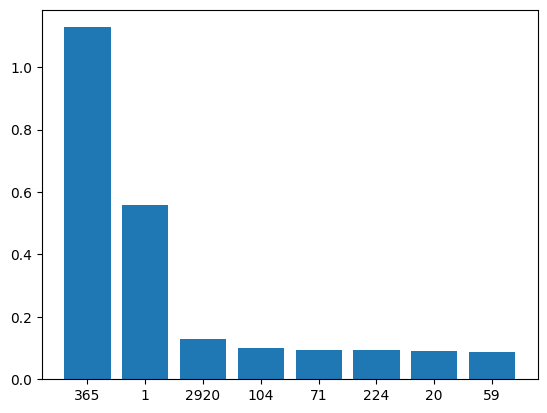

In [9]:
# check for seasonality
from collections import defaultdict

# confirm the data is sampled hourly
print(date_time[0:10])

temp = np.array(df["T (degC)"])
fft = np.fft.fft(temp)

N = len(temp) # length
T = 1 # freq
D = N * T # duration
frequency = np.fft.fftfreq(N, d=T)

fft = fft[:int(N/2)]
frequency = frequency[:int(N/2)]

# take the highest 10 frequencies and compute their amplitude
max = np.abs(fft).argsort()[::-1][:10]

frequencies = (1.0 / frequency[max]) / 24 # convert from hours to days
magnitudes = np.abs(fft[max]) * 2 / N

#print(frequencies, magnitudes)

cnt = defaultdict(lambda: 0)

for k, v in zip([str(int(x+0.1)) for x in frequencies], magnitudes):
    cnt[k] += v

plt.bar(cnt.keys(), cnt.values())

# we see clearly there is a yearly fundamental and a daily fundamental 
# (2920 days == 8 years - the number of years we have data for)

In [33]:
# given the confirmed above, we are going to transform the 
# date / time to sine waves with daily and yearly 

timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# normalized already
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day)) * 0.5
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day)) * 0.5
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year)) * 0.5
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year)) * 0.5

#plt.plot(np.array(df['Day sin'])[:250])
#plt.plot(np.array(df['Day cos'])[:250])
#plt.plot(np.array(df['Year sin'])[:250])
#plt.plot(np.array(df['Year cos'])[:250])

#plt.xlabel('Time [h]')
#plt.title('Time of day signal')

In [13]:
# timeseries, so no random split
train_df = df[ : int(0.7 * len(df))]
val_df = df[int(0.7 * len(df)) : int(0.9 * len(df))]
test_df = df[int(0.9 * len(df)) : ]

In [11]:
class WindowedDataset(Dataset):
    
    def __init__(self, df, input_window_len, target_len, shift, var_columns, target_columns, transform=None, target_transform=None) -> None:
        super().__init__()
        self.df = df
        self.input_window_len = input_window_len
        self.target_len = target_len
        self.shift = shift
        self.transform = transform
        self.target_transform = target_transform
        self.target_columns = target_columns
        self.var_columns = var_columns

        self.precompute()

    def get_input_size(self):
        return self.input_window_len * len(self.var_columns)
    
    def get_target_size(self):
        return self.target_len * len(self.target_columns)
    
    def count_channels(self):
        return len(self.var_columns)

    def __len__(self):
        return int((len(self.df) - self.target_len - self.input_window_len) / self.shift)
    
    def precompute(self):
        self.variables_ = np.array(self.df[self.var_columns])
        self.target_ = np.array(self.df[self.target_columns])
    
    def __getitem__(self, idx):

        start = idx * self.shift

        variables = self.variables_[start : start + self.input_window_len]
        variables = variables.flatten()
        
        target = self.target_[start + self.input_window_len : start + self.input_window_len + self.target_len]
        target = target.flatten()

        if self.transform:
            variables = self.transform(variables)
        if self.target_transform:
            target = self.target_transform(target)

        return variables, target
    
    def plot(self, idx, col_name):

        if not hasattr(idx, '__iter__'):
            idx = [idx]
        else:
            idx = list(idx)

        try: 

            var_tmp = self.var_columns
            target_tmp = self.target_columns

            self.var_columns = [col_name]
            self.target_columns = [col_name]
            self.precompute()

            cnt = self.input_window_len + self.target_len + (len(idx) - 1) * self.shift
            v = [0] * (self.input_window_len + (len(idx) - 1) * self.shift)
            t = [0] * (self.target_len + (len(idx) - 1) * self.shift)

            start = idx[0] * self.shift

            for i in idx:
                v_, t_ = self[i]

                ii = (i - start) * self.shift
                v [ii : ii + len(v_)] = v_ 
                t [ii : ii + len(t_)] = t_

            axis = range(start, start + cnt)
            plt.plot(axis[0 : len(v)], v)
            plt.scatter(axis[self.input_window_len : cnt], t)

            return axis, start, cnt
        
        except Exception as e:
            raise e
        finally:
            self.var_columns = var_tmp
            self.target_columns = target_tmp
            self.precompute()

    
    def plot_prediction(self, idx, col_name, model):

        if not hasattr(idx, '__iter__'):
            idx = [idx]

        axis, start, cnt = self.plot(idx, col_name=col_name)

        with torch.no_grad():
            preds = []
            # really slow way to infer
            for i in idx:
                X, _ = self[i]
                X = X[None, :] # add batch dimension
                X = X.to(device)
                y = model(X).item()

                if hasattr(y, "__iter__"):
                    preds += list(y)
                else:
                    preds.append(y)

            plt.scatter(axis[cnt - len(preds) : cnt], preds)
            plt.show()


(array([ 0.03674625,  1.36281556,  1.35069869, ...,  1.03400402,
       -0.07948006,  1.06181012]), array([1.58481661, 1.69997223, 1.66673143, 1.04346646, 0.96630033,
       0.92237499, 0.88913419, 0.86301642, 0.72055585, 0.6896894 ]))


(range(10, 120), 10, 110)

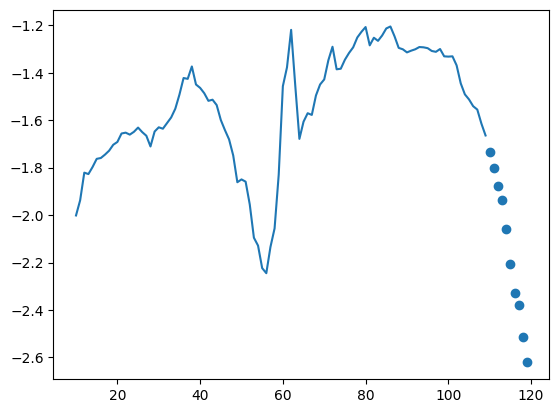

In [15]:
wds = WindowedDataset(train_df, 100, 10, 1, df.columns, "T (degC)" )

#print(len(wds))
#print(wds[0])
#print(wds[1])
print(wds[len(wds) - 1])

# the two plots below should be overlapped
wds.plot(10, "T (degC)")

In [14]:
def make_dataloader(df, input_window_len, target_len, shift):
    cols = list(df.columns)

    # make it a bit more complicated, remove the temperature completely
    # usually this is not needed for timeseries prediction
    # but more interesting to see how the models behave
    cols.remove("T (degC)")
    cols.remove("Tpot (K)")
    cols.remove("Tdew (degC)")
    
    print(cols)
    return DataLoader(
        WindowedDataset(
            df, input_window_len, target_len, shift, cols, ["T (degC)"],  
            transform=lambda v: torch.tensor(v, dtype=torch.float32),
            target_transform= lambda v: torch.tensor(v, dtype=torch.float32)
        ), 
        batch_size=128, 
        shuffle=True)

def make_loaders(input_window_len, target_len, shift):
    train_loader = make_dataloader(train_df, input_window_len, target_len, shift)
    valid_loader = make_dataloader(val_df, input_window_len, target_len, shift)
    test_loader = make_dataloader(test_df, input_window_len, target_len, shift)

    return train_loader, valid_loader, test_loader

In [38]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))

def eval_(model, dl):
    res = []
    with torch.no_grad():
        for batch, (X, y) in enumerate(dl):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            res.append(RMSELoss(y, pred).item())

            # take only the first 20 batches top
            if batch > 20:
                break

    return np.mean(res)

def eval(model, train_ds, valid_ds, test_ds):
    print("Training loss:", eval_(model, dl=train_ds))
    print("Validation loss:", eval_(model, dl=valid_ds))
    print("Test loss:", eval_(model, dl=test_ds))

def create_trainer(dataloader, model, epochs):

    try:
        torch._dynamo.config.suppress_errors = True
        model = torch.compile(model)
    except:
        print ("torch.compile() not available.")

    losses = []
    m = model
    
    loss_fn = RMSELoss
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

    def train():

        size = len(dataloader.dataset)
        model.train()

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # save losses for plotting
            losses.append(loss.item())

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    def trainer():

        model_str = str(m)
        model_str = ''.join([s for s in model_str if s.isalnum()])
        model_str = model_str[0 : min(150, len(model_str))]

        if path.exists(model_str):
            return torch.load(model_str)
        else:
            for i in range(epochs):
                print("Epoch ", i)
                train()
            plt.plot(losses)
            plt.show()
            torch.save(m, model_str)
            return m

    return trainer

In [39]:
class BasicLinear(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, target_size),
        )

    def forward(self, x):
        return self.linear_stack(x)
    
t, v, tt = make_loaders(1, 1, 1)
model = BasicLinear(t.dataset.get_input_size(), t.dataset.get_target_size()).to(device)
print(model)

['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
BasicLinear(
  (linear_stack): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
  )
)


torch.compile() not available.
Epoch  0
loss: 1.051254  [  128/49061]
loss: 0.909737  [12928/49061]
loss: 0.624385  [25728/49061]
loss: 0.616867  [38528/49061]
Epoch  1
loss: 0.494105  [  128/49061]
loss: 0.429925  [12928/49061]
loss: 0.294635  [25728/49061]
loss: 0.269186  [38528/49061]
Epoch  2
loss: 0.201153  [  128/49061]
loss: 0.181230  [12928/49061]
loss: 0.174550  [25728/49061]
loss: 0.189437  [38528/49061]
Epoch  3
loss: 0.184003  [  128/49061]
loss: 0.196448  [12928/49061]
loss: 0.188084  [25728/49061]
loss: 0.158829  [38528/49061]
Epoch  4
loss: 0.212646  [  128/49061]
loss: 0.185239  [12928/49061]
loss: 0.165491  [25728/49061]
loss: 0.172691  [38528/49061]


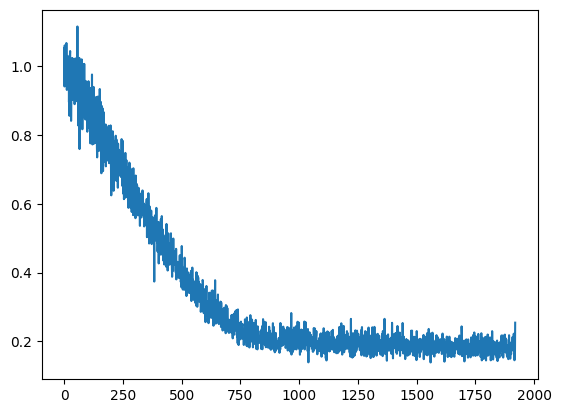

Training loss: 0.18462089449167252
Validation loss: 0.1541244082830169
Test loss: 0.15203828804872252


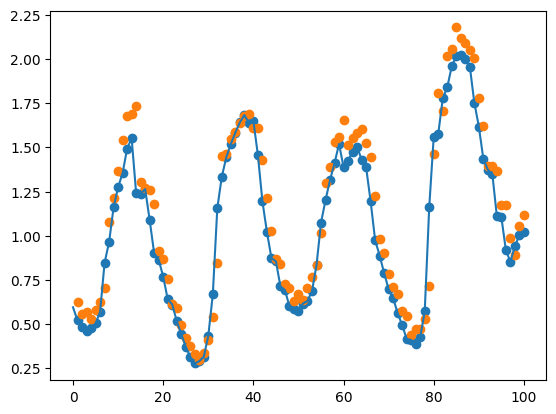

In [40]:
model = create_trainer(t, model, 5)()
eval(model, t, v, tt)
v.dataset.plot_prediction(range(0, 100), "T (degC)", model)

In [41]:
# deep learning, dense, given 24h of data, predict 1h in advance,
# stride of 1h
class DNNRegressor(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.ReLU(),
            nn.Linear(input_size, 64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, target_size)
        )

    def forward(self, x):
        return self.linear_stack(x)
    

t, v, tt = make_loaders(24, 1, 1)
model = DNNRegressor(t.dataset.get_input_size(), t.dataset.get_target_size()).to(device)
print(model)
print("Total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
DNNRegressor(
  (linear_stack): Sequential(
    (0): Linear(in_features=384, out_features=384, bias=True)
    (1): ReLU()
    (2): Linear(in_features=384, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)
Total params:  176705


torch.compile() not available.
Epoch  0
loss: 1.020582  [  128/49038]
loss: 0.174629  [12928/49038]
loss: 0.157358  [25728/49038]
loss: 0.109021  [38528/49038]
Epoch  1
loss: 0.117007  [  128/49038]
loss: 0.094742  [12928/49038]
loss: 0.095951  [25728/49038]
loss: 0.088265  [38528/49038]
Epoch  2
loss: 0.096154  [  128/49038]
loss: 0.091467  [12928/49038]
loss: 0.086405  [25728/49038]
loss: 0.095523  [38528/49038]
Epoch  3
loss: 0.078144  [  128/49038]
loss: 0.107184  [12928/49038]
loss: 0.117971  [25728/49038]
loss: 0.076346  [38528/49038]
Epoch  4
loss: 0.088297  [  128/49038]
loss: 0.102564  [12928/49038]
loss: 0.114382  [25728/49038]
loss: 0.086064  [38528/49038]


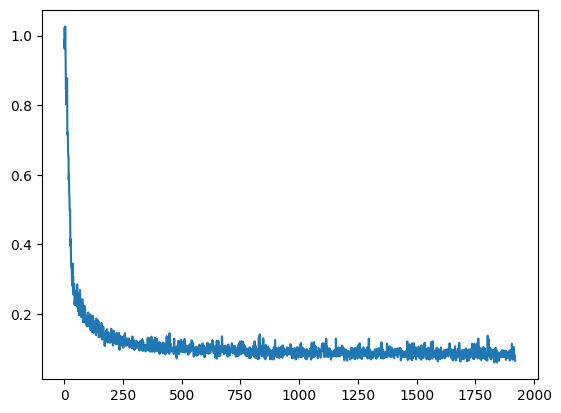

Training loss: 0.08886224979704077
Validation loss: 0.09867735647342422
Test loss: 0.09533774852752686


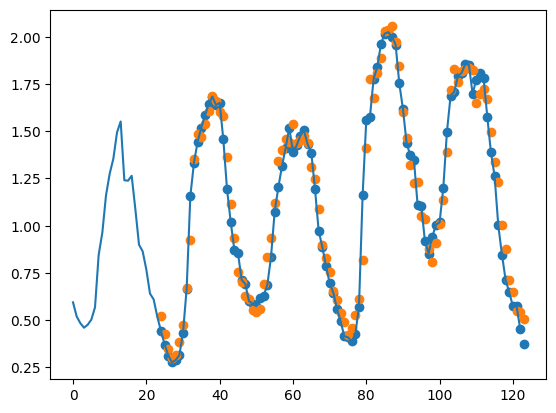

In [42]:
model = create_trainer(t, model, 5)()
eval(model, t, v, tt)
v.dataset.plot_prediction(range(0, 100), "T (degC)", model)

In [43]:
# with convolutional NN
class CNNRegressor(nn.Module):
    def __init__(self, in_channels, target_size):
        super().__init__()

        self.in_channels = in_channels

        self.seq_stack = nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=256, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(output_size=8),
            nn.Flatten(),
            nn.Linear(256 * 8, 64),
            #nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, target_size)
        )

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], int(x.shape[1] / self.in_channels), self.in_channels)).permute(0, 2, 1)
        return self.seq_stack(x)
    

t, v, tt = make_loaders(24, 1, 1)
model = CNNRegressor(t.dataset.count_channels(), t.dataset.get_target_size()).to(device)
print(model)
print("Total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
CNNRegressor(
  (seq_stack): Sequential(
    (0): Conv1d(16, 256, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=8)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2048, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features

torch.compile() not available.
Epoch  0
loss: 1.079771  [  128/49038]
loss: 0.186680  [12928/49038]
loss: 0.150596  [25728/49038]
loss: 0.131693  [38528/49038]
Epoch  1
loss: 0.116421  [  128/49038]
loss: 0.113846  [12928/49038]
loss: 0.096624  [25728/49038]
loss: 0.106989  [38528/49038]
Epoch  2
loss: 0.091617  [  128/49038]
loss: 0.091664  [12928/49038]
loss: 0.084335  [25728/49038]
loss: 0.105101  [38528/49038]
Epoch  3
loss: 0.089308  [  128/49038]
loss: 0.098350  [12928/49038]
loss: 0.095969  [25728/49038]
loss: 0.085090  [38528/49038]
Epoch  4
loss: 0.071659  [  128/49038]
loss: 0.092766  [12928/49038]
loss: 0.093368  [25728/49038]
loss: 0.111116  [38528/49038]


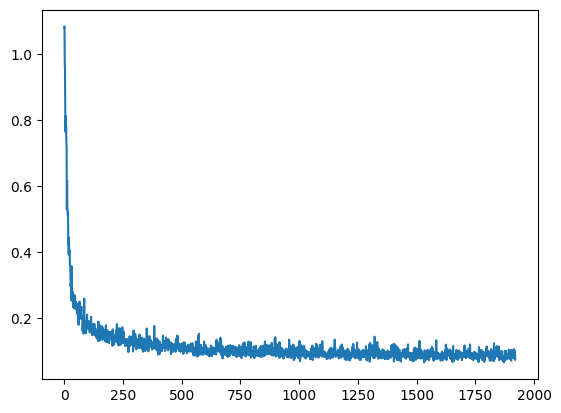

Training loss: 0.09295224229043181
Validation loss: 0.09933860566128384
Test loss: 0.09111841869625179


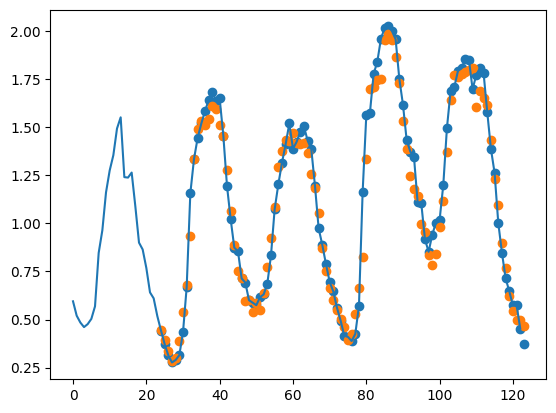

In [44]:
model = create_trainer(t, model, 5)()
eval(model, t, v, tt)
v.dataset.plot_prediction(range(0, 100), "T (degC)", model)

In [45]:
# checking the convolution correctness

x = torch.tensor(
    [
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
        [1, 2, 3, 4, 5, 6, 7, 8],
    ], dtype=torch.float32)

x = torch.reshape(x, (x.shape[0], int(x.shape[1] / 2), 2)).permute(0, 2, 1)
print(x.numpy())


[[[1. 3. 5. 7.]
  [2. 4. 6. 8.]]

 [[1. 3. 5. 7.]
  [2. 4. 6. 8.]]

 [[1. 3. 5. 7.]
  [2. 4. 6. 8.]]]


In [46]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, target_size):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=input_size * 2, 
            num_layers = 4,
            batch_first = True)
        
        self.input_size = input_size # number of channels
        
        self.linear = nn.Linear(input_size * 2, target_size)

    def forward(self, x):

        seq_len = int(x.shape[1] / self.input_size)
        x = torch.reshape(x, (x.shape[0], seq_len, self.input_size)).permute(0, 1, 2)
        ret_lstm, (hn, cn) = self.lstm(x)
        lin_input = ret_lstm[:, -1, :] # take the last output from the sequence
        return self.linear(lin_input)
    

t, v, tt = make_loaders(24, 1, 1)
model = LSTMRegressor(input_size=t.dataset.count_channels(), target_size=t.dataset.get_target_size()).to(device)
print(model)
print("Total params: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
['p (mbar)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'Wx', 'Wy', 'max Wx', 'max Wy', 'Day sin', 'Day cos', 'Year sin', 'Year cos']
LSTMRegressor(
  (lstm): LSTM(16, 32, num_layers=4, batch_first=True)
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
Total params:  31777


torch.compile() not available.
Epoch  0
loss: 1.103312  [  128/49038]
loss: 0.678612  [12928/49038]
loss: 0.416042  [25728/49038]
loss: 0.281821  [38528/49038]
Epoch  1
loss: 0.250492  [  128/49038]
loss: 0.228384  [12928/49038]
loss: 0.222057  [25728/49038]
loss: 0.209670  [38528/49038]
Epoch  2
loss: 0.199009  [  128/49038]
loss: 0.171381  [12928/49038]
loss: 0.157057  [25728/49038]
loss: 0.149900  [38528/49038]
Epoch  3
loss: 0.191742  [  128/49038]
loss: 0.130941  [12928/49038]
loss: 0.105325  [25728/49038]
loss: 0.115826  [38528/49038]
Epoch  4
loss: 0.097192  [  128/49038]
loss: 0.097106  [12928/49038]
loss: 0.121512  [25728/49038]
loss: 0.125232  [38528/49038]


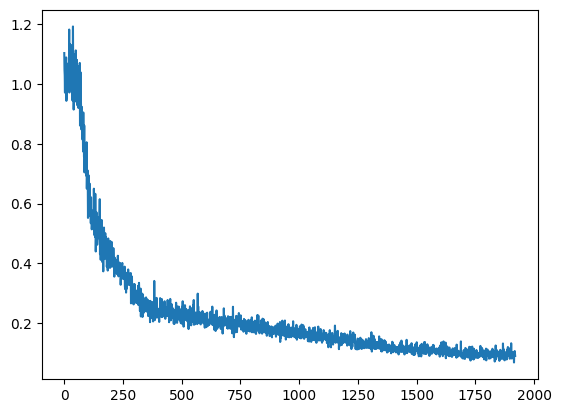

Training loss: 0.09376453438943083
Validation loss: 0.09424543075940826
Test loss: 0.09131628918376836


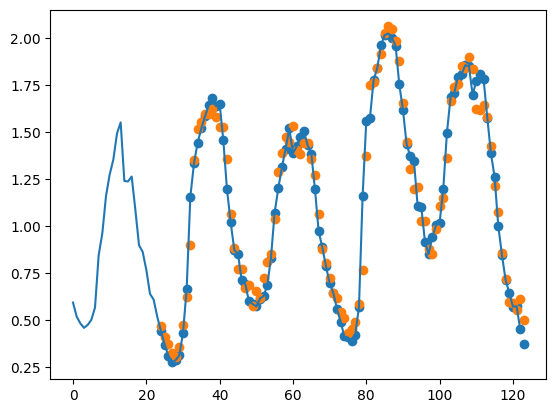

In [47]:
model = create_trainer(t, model, 5)()
eval(model, t, v, tt)
v.dataset.plot_prediction(range(0, 100), "T (degC)", model)